# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
# Ejemplo de optimizacion bayesiana, univariada

# limpio la memoria
rm(list = ls()) # remove all objects
gc() # garbage collection

require("data.table")
# paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width = 20, repr.plot.height = 10)


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,653120,34.9,1448491,77.4,1231766,65.8
Vcells,1214047,9.3,8388608,64.0,1924979,14.7


Loading required package: data.table

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Loading required package: smoof

Loading required package: checkmate


Attaching package: ‘checkmate’


The following object is masked from ‘package:DiceKriging’:

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [2]:
func_univariada01 <- function(x) {
  y <- -2 * (x + 13) * (x - 3) * (x - 7) * (x - 19)

  return(y)
}


Grafico la funcion

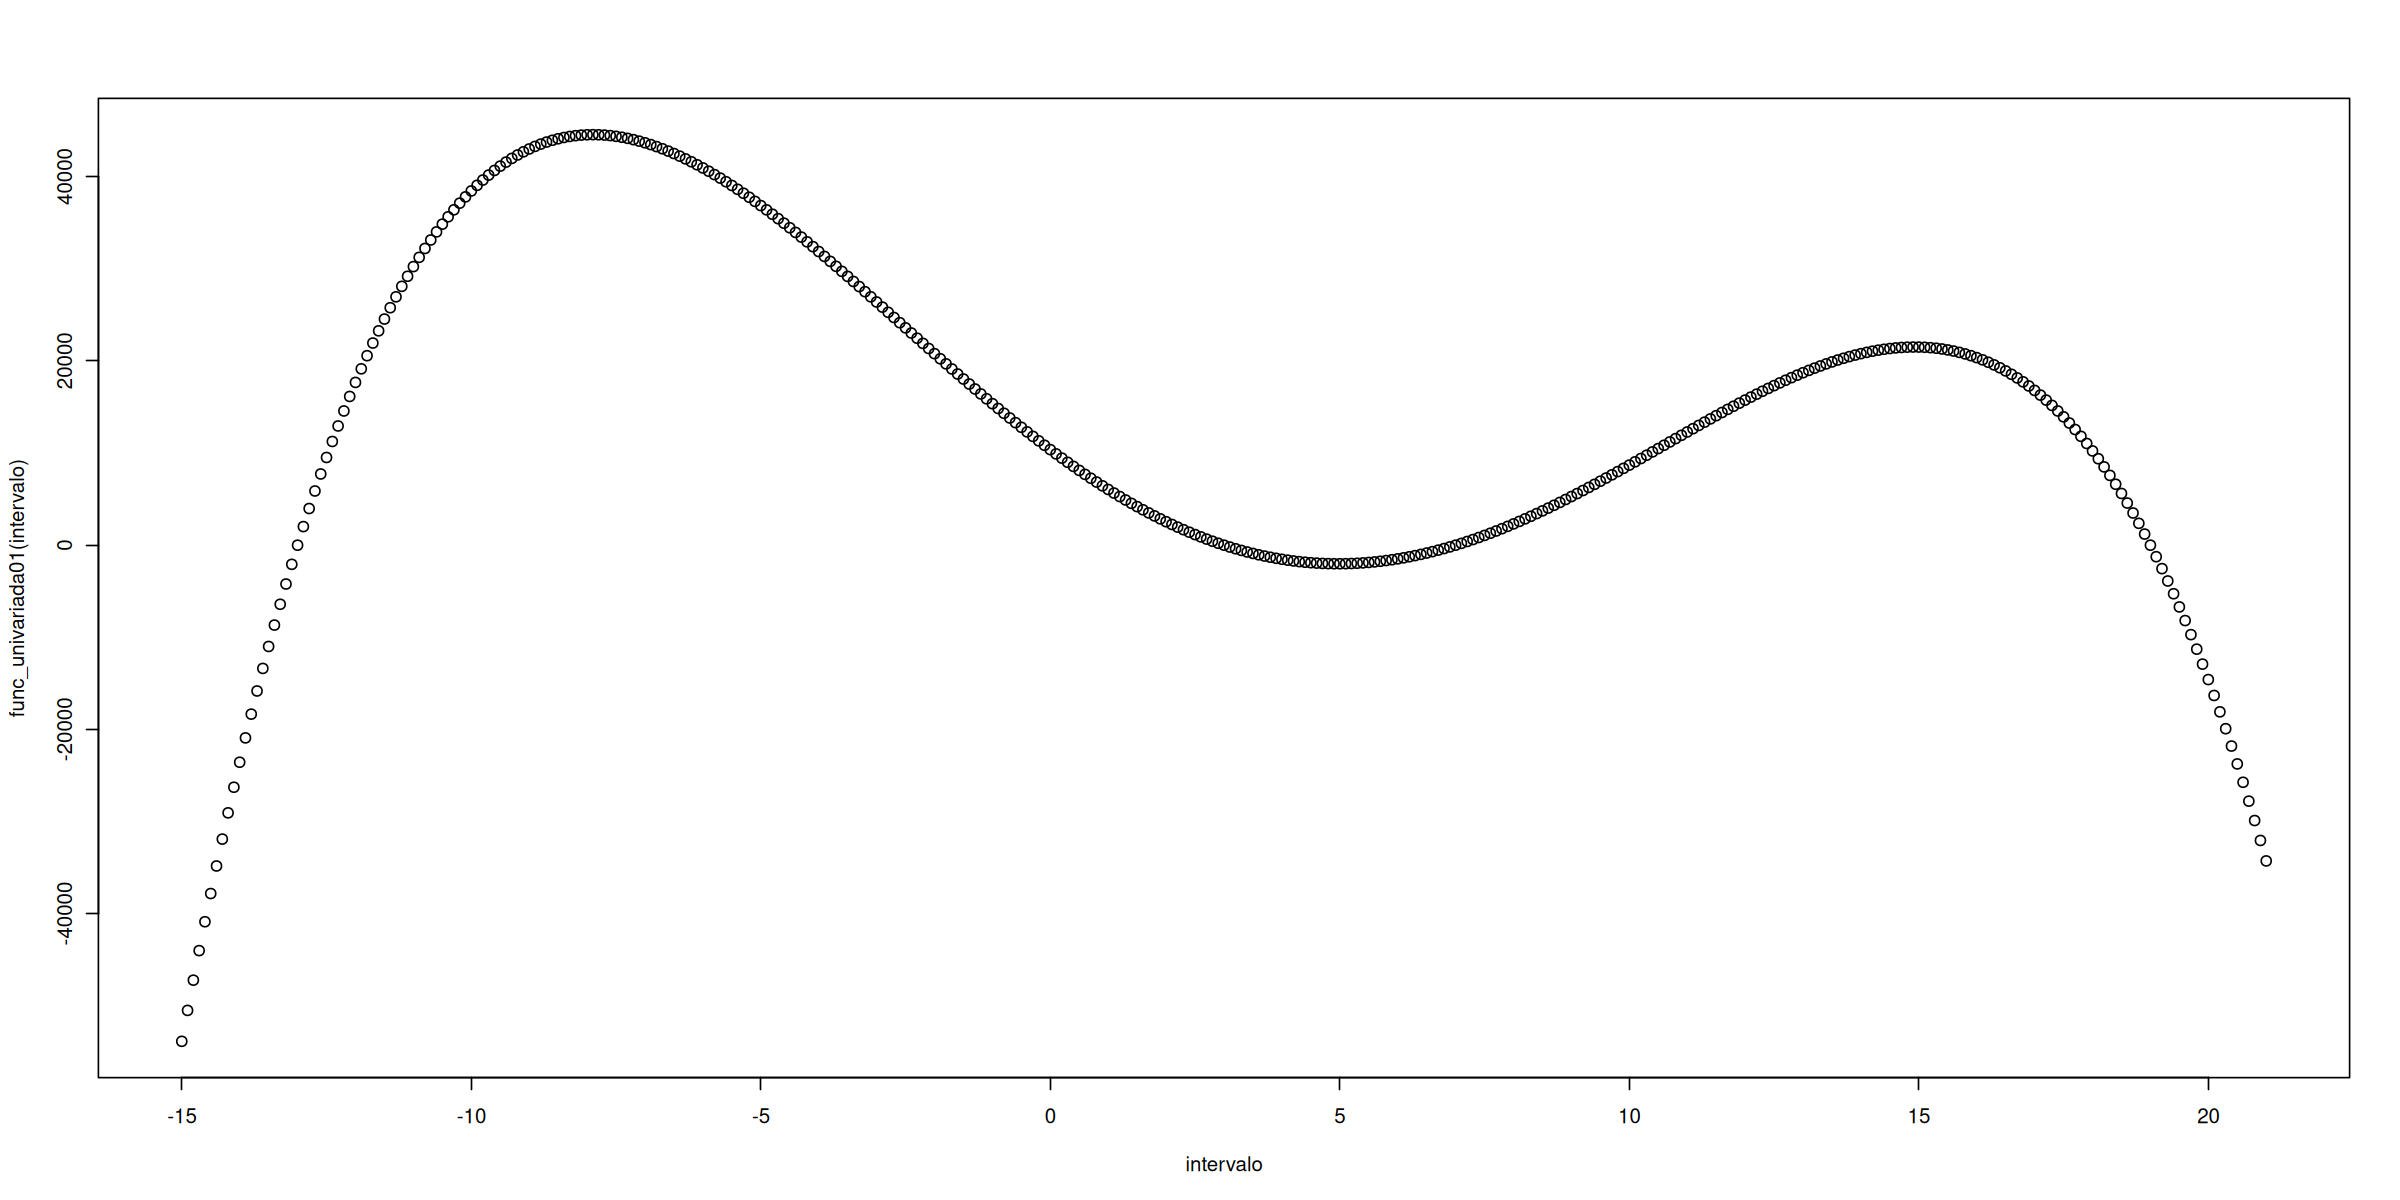

In [3]:
intervalo <- seq(-15, 21, 0.1)
plot(intervalo, func_univariada01(intervalo))


La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [4]:
obj.fun <- makeSingleObjectiveFunction(
    fn = func_univariada01,
    minimize = FALSE, # estoy Maximizando la ganancia
    par.set = makeParamSet(makeNumericParam("x", lower = -100, upper = 100)),
)


ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [5]:
fproxy <- makeLearner(
    cl = "regr.km",
    predict.type = "se",
    covtype = "matern3_2"
)


ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [6]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())
ctrl <- setMBOControlTermination(ctrl, iters = 25)


finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [7]:
run <- mbo(
    fun = obj.fun,
    learner = fproxy,
    control = ctrl
)


Computing y column(s) for design. Not provided.

[mbo] 0: x=40.6 : y = -2.92e+06 : 0.0 secs : initdesign

[mbo] 0: x=-35.3 : y = -3.91e+06 : 0.0 secs : initdesign

[mbo] 0: x=70.9 : y = -3.79e+07 : 0.0 secs : initdesign

[mbo] 0: x=-55.8 : y = -2.36e+07 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -71.65295 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       71.653  |proj g|=   0.00098192
At iterate     1  f =       71.653  |proj g|=    0.00098028
At iterate     2  f =       71.653  |proj g|=    0.00029429
At iterate     3  f =       71.653  |proj g|=    0.00014915
At iterate     4  f =       71.653  |proj g|=    6.4044e-05
At iterate     5  f =       71.653  |proj g|=    2.9838e-05
At iterate     6  f =       71.653  |proj g|=    1.3666e-05
At iterate     7  f =       71.653  |proj g|=    6.3712e-06
At iterate     8  f =       71.653  |proj g|=    2.9773e-06
At iterate     9  f =       71.653 

[mbo] 1: x=39.3 : y = -2.48e+06 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -87.54376 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       87.544  |proj g|=     0.016186
At iterate     1  f =       87.543  |proj g|=      0.016163
At iterate     2  f =       87.492  |proj g|=     0.0036888
At iterate     3  f =       87.491  |proj g|=    0.00026254
At iterate     4  f =       87.491  |proj g|=    2.2829e-05
At iterate     5  f =       87.491  |proj g|=    1.2522e-07

iterations 5
function evaluations 8
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.25218e-07
final functio

[mbo] 2: x=-24 : y = -7.97e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -104.5969 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        104.6  |proj g|=    0.0040654
At iterate     1  f =        104.6  |proj g|=     0.0040606
At iterate     2  f =       104.59  |proj g|=      0.000832
At iterate     3  f =       104.59  |proj g|=    0.00013205
At iterate     4  f =       104.59  |proj g|=    3.6137e-06
At iterate     5  f =       104.59  |proj g|=    1.6223e-08

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.62228e-08
final functio

[mbo] 3: x=6.68 : y = -577 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -122.1564 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       122.16  |proj g|=     0.010204
At iterate     1  f =       122.16  |proj g|=      0.010204
At iterate     2  f =       121.82  |proj g|=    0.00039012
Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
At iterate     3  f =       121.82  |proj g|=    0.00027802
At iterate     4  f =       121.82  |proj g|=    5.0463e-06
At iterate     5  f =       121.82  |proj g|=     6.679e-08

iterations 5
function evaluations 12
segments explored during Cauchy searches 6
BFGS updates skipp

[mbo] 4: x=20.7 : y = -2.7e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -137.9803 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       137.98  |proj g|=   0.00066581
At iterate     1  f =       137.98  |proj g|=    0.00066557
At iterate     2  f =       137.98  |proj g|=    3.4771e-05
At iterate     3  f =       137.98  |proj g|=    1.6994e-06
At iterate     4  f =       137.98  |proj g|=    4.0865e-09

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.08652e-09
final function value 137.98

F = 137.98
final  value 137.979692 
converge

[mbo] 5: x=-8.12 : y = 4.45e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -153.8408 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       153.84  |proj g|=    0.0012432
At iterate     1  f =       153.84  |proj g|=     0.0012429
At iterate     2  f =       153.84  |proj g|=    0.00010923
At iterate     3  f =       153.84  |proj g|=    1.0687e-05
At iterate     4  f =       153.84  |proj g|=    1.0446e-07

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.04455e-07
final function value 153.838

F = 153.838
final  value 153.837938 
conver

[mbo] 6: x=-0.952 : y = 1.51e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -168.5761 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       168.58  |proj g|=   0.00036072
At iterate     1  f =       168.58  |proj g|=    0.00036066

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000360664
final function value 168.576

F = 168.576
final  value 168.576055 
converged


[mbo] 7: x=14 : y = 2.07e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -183.0651 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       183.07  |proj g|=   0.00062159
At iterate     1  f =       183.07  |proj g|=    0.00062151

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000621511
final function value 183.065

F = 183.065
final  value 183.065078 
converged


[mbo] 8: x=-14.8 : y = -4.66e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -197.5569 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       197.56  |proj g|=   0.00011657
At iterate     1  f =       197.56  |proj g|=    0.00011656

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000116562
final function value 197.557

F = 197.557
final  value 197.556938 
converged


[mbo] 9: x=26.8 : y = -2.96e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -211.9862 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       211.99  |proj g|=   0.00055549
At iterate     1  f =       211.99  |proj g|=    0.00055546

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000555463
final function value 211.986

F = 211.986
final  value 211.986170 
converged


[mbo] 10: x=-4.66 : y = 3.52e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -225.2561 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       225.26  |proj g|=   0.00014807
At iterate     1  f =       225.26  |proj g|=    0.00014807

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000148067
final function value 225.256

F = 225.256
final  value 225.256059 
converged


[mbo] 11: x=10.4 : y = 1.02e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -238.486 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       238.49  |proj g|=   1.6112e-06
Line search cannot locate an adequate point after 20 function
and gradient evaluations
final  value 238.486012 
stopped after 0 iterations


[mbo] 12: x=-11.3 : y = 2.73e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -251.5029 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        251.5  |proj g|=   0.00029454
At iterate     1  f =        251.5  |proj g|=    0.00029453

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000294534
final function value 251.503

F = 251.503
final  value 251.502875 
converged


[mbo] 13: x=2.79 : y = 453 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -264.599 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        264.6  |proj g|=   0.00074985
At iterate     1  f =        264.6  |proj g|=    0.00074982

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000749818
final function value 264.599

F = 264.599
final  value 264.599008 
converged


[mbo] 14: x=17.2 : y = 1.57e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -277.5187 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       277.52  |proj g|=    0.0010585
At iterate     1  f =       277.52  |proj g|=     0.0010584
At iterate     2  f =       277.51  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 277.514

F = 277.514
final  value 277.513738 
converged


[mbo] 15: x=-6.45 : y = 4.24e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -289.4754 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       289.48  |proj g|=    0.0016118
At iterate     1  f =       289.48  |proj g|=     0.0016117
At iterate     2  f =       289.47  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 289.472

F = 289.472
final  value 289.471818 
converged


[mbo] 16: x=-9.62 : y = 4.06e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -301.229 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       301.23  |proj g|=    0.0023319
At iterate     1  f =       301.23  |proj g|=     0.0023318
At iterate     2  f =       301.22  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 301.221

F = 301.221
final  value 301.221300 
converged


[mbo] 17: x=-2.88 : y = 2.57e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -313.1817 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       313.18  |proj g|=    0.0030517
At iterate     1  f =       313.18  |proj g|=     0.0030515
At iterate     2  f =       313.17  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 313.169

F = 313.169
final  value 313.169041 
converged


[mbo] 18: x=12.2 : y = 1.65e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -325.5334 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       325.53  |proj g|=     0.010469
At iterate     1  f =       325.53  |proj g|=      0.010467
At iterate     2  f =       325.12  |proj g|=     0.0039091
At iterate     3  f =       325.09  |proj g|=             0

iterations 3
function evaluations 4
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 325.09

F = 325.09
final  value 325.090065 
converged


[mbo] 19: x=15.6 : y = 2.11e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -336.874 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       336.87  |proj g|=    0.0049688
At iterate     1  f =       336.87  |proj g|=     0.0049684
At iterate     2  f =       336.82  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 336.818

F = 336.818
final  value 336.817609 
converged


[mbo] 20: x=0.893 : y = 6.47e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -348.7544 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       348.75  |proj g|=    0.0052325
At iterate     1  f =       348.75  |proj g|=     0.0052321
At iterate     2  f =       348.72  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 348.722

F = 348.722
final  value 348.722232 
converged


[mbo] 21: x=8.55 : y = 3.86e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -360.6484 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       360.65  |proj g|=    0.0061141
At iterate     1  f =       360.65  |proj g|=     0.0061136
At iterate     2  f =        360.6  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 360.597

F = 360.597
final  value 360.597362 
converged


[mbo] 22: x=-18 : y = -1.92e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -373.7157 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       373.72  |proj g|=    0.0068385
At iterate     1  f =       373.72  |proj g|=     0.0068379
At iterate     2  f =       373.66  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 373.657

F = 373.657
final  value 373.656567 
converged


[mbo] 23: x=-7.31 : y = 4.42e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -384.4261 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       384.43  |proj g|=    0.0078084
At iterate     1  f =       384.43  |proj g|=     0.0078076
At iterate     2  f =       384.34  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 384.339

F = 384.339
final  value 384.339125 
converged


[mbo] 24: x=23.1 : y = -9.7e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -396.9027 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        396.9  |proj g|=    0.0074889
At iterate     1  f =        396.9  |proj g|=     0.0074882
At iterate     2  f =       396.89  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 396.894

F = 396.894
final  value 396.894439 
converged


[mbo] 25: x=4.73 : y = -1.99e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  253.4233 
  - best initial criterion value(s) :  -408.6985 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        408.7  |proj g|=    0.0080671
At iterate     1  f =        408.7  |proj g|=     0.0080663
At iterate     2  f =        408.7  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 408.697

F = 408.697
final  value 408.696571 
converged


In [8]:
tb_resultados <- as.data.table(run$opt.path)


In [9]:
tb_resultados


x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
40.5914939,-2.922318e+06,0,NA,NA,0.008,NA,NA,NA,initdesign,NA,NA,NA
-35.2793918,-3.914372e+06,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
70.9374725,-3.787316e+07,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-55.7741925,-2.360105e+07,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
39.2667287,-2.479147e+06,1,NA,NA,0.000,-2374755.324,NA,0.151,infill_ei,0.482,10892832.17,-7680163.818
-24.0355243,-7.969736e+05,2,NA,NA,0.000,-2289790.501,NA,0.016,infill_ei,0.199,11021475.59,-7640430.032
6.6764760,-5.768334e+02,3,NA,NA,0.000,-3137815.763,NA,0.022,infill_ei,0.218,12910663.79,-5497998.952
20.6600271,-2.695892e+04,4,NA,NA,0.000,-1875258.747,NA,0.018,infill_ei,0.161,4943932.87,-197888.162
-8.1150425,4.450631e+04,5,NA,NA,0.000,-1321753.105,NA,0.015,infill_ei,0.166,3432406.33,-96810.961


In [10]:
tb_resultados[which.max(tb_resultados$y)]


x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-8.115043,44506.31,5,NA,NA,0,-1321753,NA,0.015,infill_ei,0.166,3432406,-96810.96


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?